In [ ]:
# SMA and EMA idicators backtest with KPIs (CAGR, MaxDrawdown, Sharpe Ratio, Win Rate, Profit Factor)

/var/folders/49/q5q_jjls7tq8knq4wvstm17m0000gn/T/ipykernel_18881/939048101.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/49/q5q_jjls7tq8knq4wvstm17m0000gn/T/ipykernel_18881/939048101.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/49/q5q_jjls7tq8knq4wvstm17m0000gn/T/ipykernel_18881/939048101.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/49/q5q_jjls7tq8knq4wvstm17m0000gn/T/ipykernel_18881/939048101.py:19: FutureWarning: YF.download() has changed argument auto

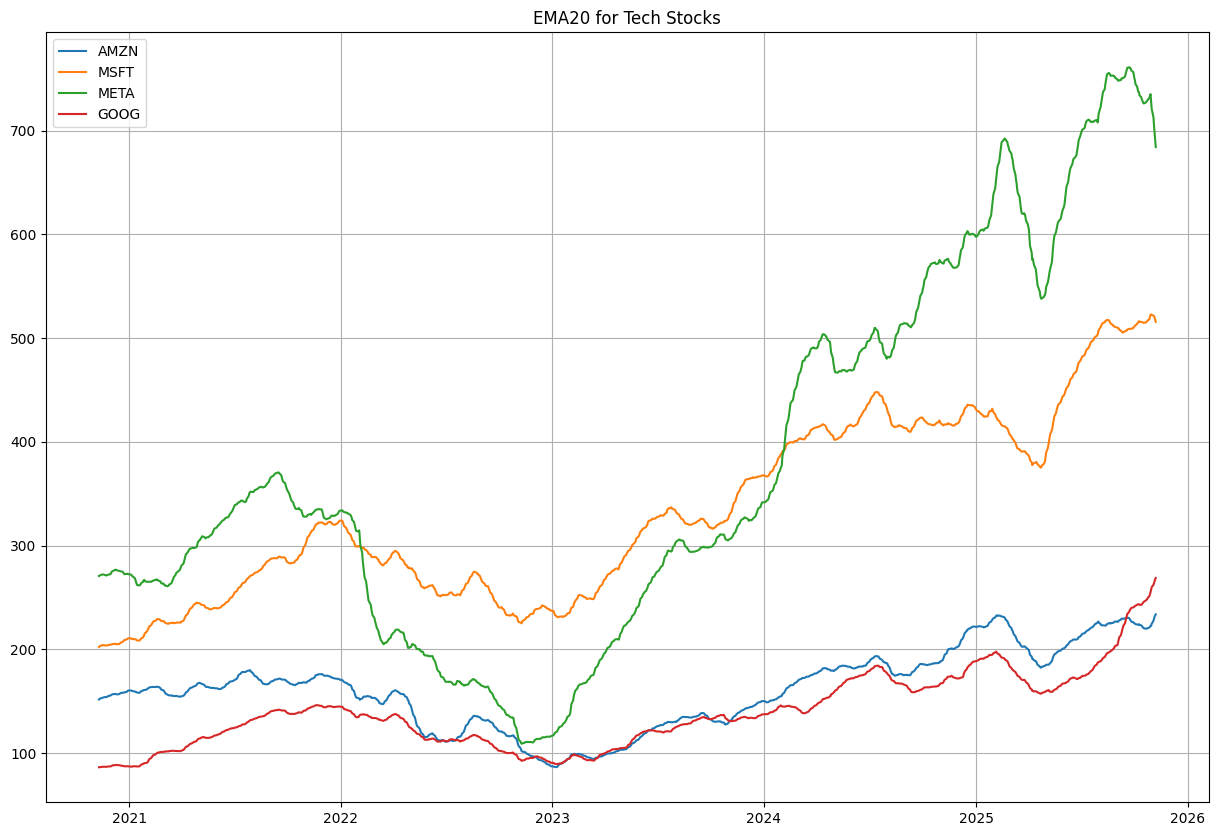

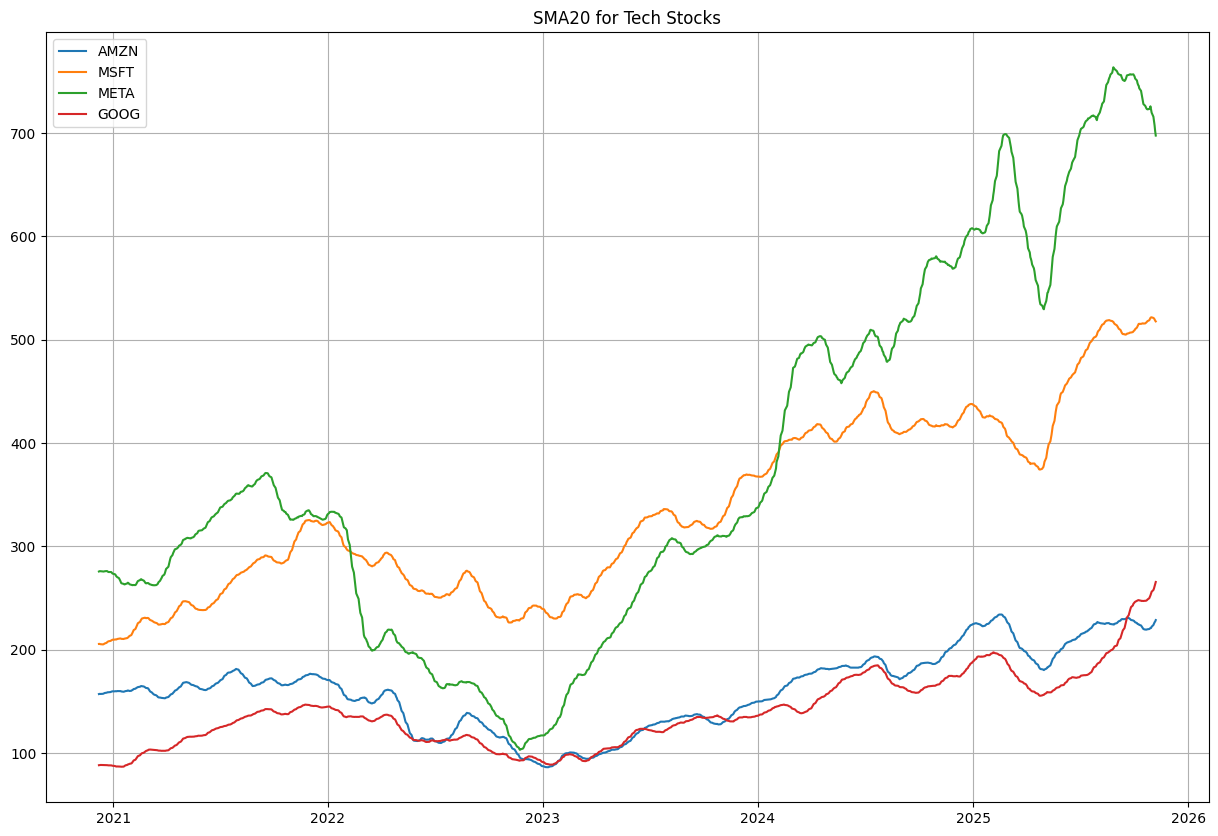

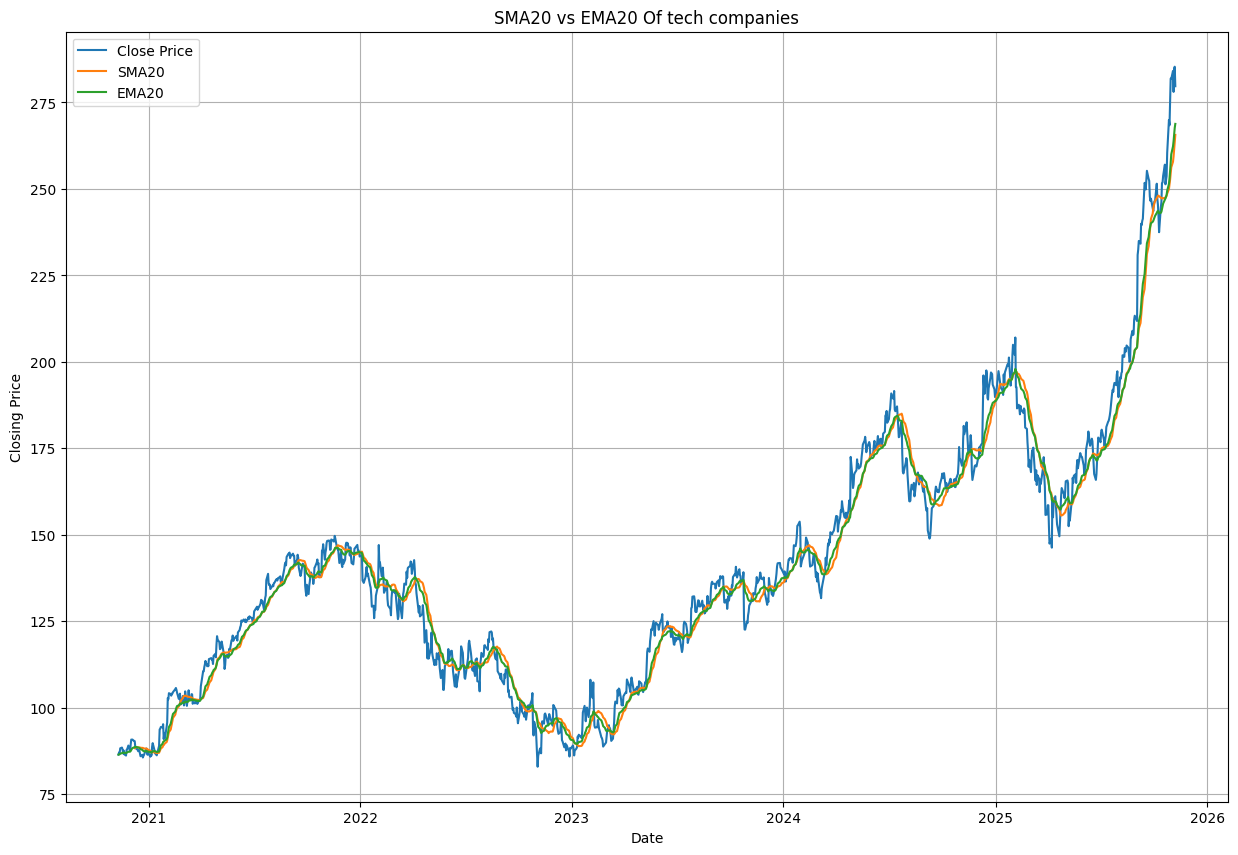

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 

tickers = ["AMZN", "MSFT", "META", "GOOG"]  

#download data of apple last 5 years 
start_date = dt.datetime.today() - dt.timedelta(1825) # last 5 years
end_date = dt.datetime.today()

#closing prices
cl_price = pd.DataFrame()

ohlcv_data = {}

for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if 'Adj Close' in df.columns:
        cl_price[ticker] = df['Adj Close']
    else:
        cl_price[ticker] = df['Close']

    #indicators EMA and SMA 
    df["EMA20"] = df["Close"].ewm(span = 20, adjust = False).mean()
    df["EMA50"] = df["Close"].ewm(span = 50, adjust = False).mean()
    df["SMA20"]= df["Close"].rolling(window=20).mean()
    df["SMA50"]= df["Close"].rolling(window=50).mean()

    ohlcv_data[ticker] = df


plt.figure(figsize=(15,10))
plt.title("EMA20 for Tech Stocks")

for ticker in tickers:
    plt.plot(ohlcv_data[ticker]["EMA20"], label=ticker)

plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,10))
plt.title("SMA20 for Tech Stocks")

for ticker in tickers:
    plt.plot(ohlcv_data[ticker]["SMA20"], label=ticker)

plt.legend()
plt.grid(True)
plt.show()

# Grafik
plt.figure(figsize=(15,10))
plt.title("SMA20 vs EMA20 Of tech companies")
plt.plot(df["Close"], label="Close Price")
plt.plot(df["SMA20"], label="SMA20")
plt.plot(df["EMA20"], label=["EMA20"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show() 

In [ ]:

def CAGR(DF):
    df = DF.copy()
    df["return"] = df["Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    n = len(df) / 252  # number of open day in a year
    cagr = (df["cum_return"].iloc[-1]) ** (1/n) - 1
    return cagr


def max_drawdown(DF):
    df = DF.copy()
    df["daily_return"] = df["Close"].pct_change()
    df["cum_return"] = (1+df["daily_return"]).cumprod()# cumulative change of a portfolio
    df["max"]= df["cum_return"].cummax()
    df["drawdown"] = (df["cum_return"]-df["max"]) / df["max"]
    min_drawdown = df["drawdown"].min()  
    return min_drawdown

def sharpe_ratio(DF, rf = 0.03):
    df = DF.copy()
    #daily return 
    df["daily_ret"] = df["Close"].pct_change()
    avg_ret = df["daily_ret"].mean()
    daily_volt = df["daily_ret"].std()
    sharpe = ((avg_ret - (rf/252)) / daily_volt) * np.sqrt(252)
    return sharpe 
"""
def sharpe_ratio(DF, rf):
    df = DF.copy()
    return (CAGR(df) - rf) / volatility(df)
"""

def get_trade_list(df):

    trade_list = []
    entry_price = None
    df["Signal"] = 0
    for i in range(len(df)):
        if(df["EMA20"].iloc[i]> df["EMA50"].iloc[i]):
            df.loc[df.index[i],"Signal"] = 1
        elif(df["EMA20"].iloc[i] < df["EMA50"].iloc[i]):
            df.loc[df.index[i], "Signal"] = -1
    
    for i in range(len(df)):
        signal = df["Signal"].iloc[i]
        close = df["Close"].iloc[i]

        if signal==1 and entry_price is None:
            entry_price= close
        elif signal==-1 and entry_price is not None:
            exit_price =close
            trade= exit_price - entry_price
            trade_list.append(trade)
            entry_price = None
    return trade_list

def win_rate(trade_returns):
    if len(trade_returns) == 0:
        return 0
    trade_returns = np.array(trade_returns)
    return (trade_returns > 0).mean() * 100

def profit_factor(trade_returns):

    trade_returns = np.array(trade_returns)
    gross_profit = trade_returns[trade_returns > 0].sum()
    gross_loss = abs(trade_returns[trade_returns < 0].sum())
    if gross_loss == 0:
        return np.inf  # kayıp yoksa PF sonsuz
    return gross_profit / gross_loss

for ticker in ohlcv_data:
    trade_ret = get_trade_list(ohlcv_data[ticker])
    print("CAGR of {} = {:.2%}".format(ticker, CAGR(ohlcv_data[ticker])))
    print("Max drawndown of {} = {:.2%}".format(ticker, max_drawdown(ohlcv_data[ticker])))
    print("Sharpe ratio of {} = {:.2%}".format(ticker, sharpe_ratio(ohlcv_data[ticker])))
    print("Win rate of {} = {:.2%}".format(ticker, win_rate(trade_ret)/100))
    print("Profit facator of {} = {:.2}".format(ticker, profit_factor(trade_ret)))